In [343]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen, Gen2
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *
from anomalyDetection import *
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell
        
p=2       
args = GENV(n_channels=1,
            latent_dims=10,
            n_samples=100,
            shuffle=False,
            periode=p,
            L=288*p,
            min_max=False,
            num_layers=3,
            first_kernel=288,
            modified=False)
effects = {
    "Pulse": {
        "occurances":1,
        "max_amplitude":5,   
        "interval":40,
        "start":None
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.002,
        "type":"linear",
        "start":None
        },
    "Seasonality": {
        "occurances":10,
        "frequency_per_week":(56, 63), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":-5
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":30,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [344]:
from importlib import reload
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
args.num_embed = args.enc_out**2 
args.robust = False
vae = Variational_Autoencoder(args,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder #MST_VAE_Decoder,
                           )
vq = VQ_MST_VAE(args,
                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                v_quantizer = VQ_Quantizer) #10 5

vae = vae.to(args.device)
vq = vq.to(args.device)

opt_vae = optim.Adam(vae.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945
opt_vq = optim.Adam(vq.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945

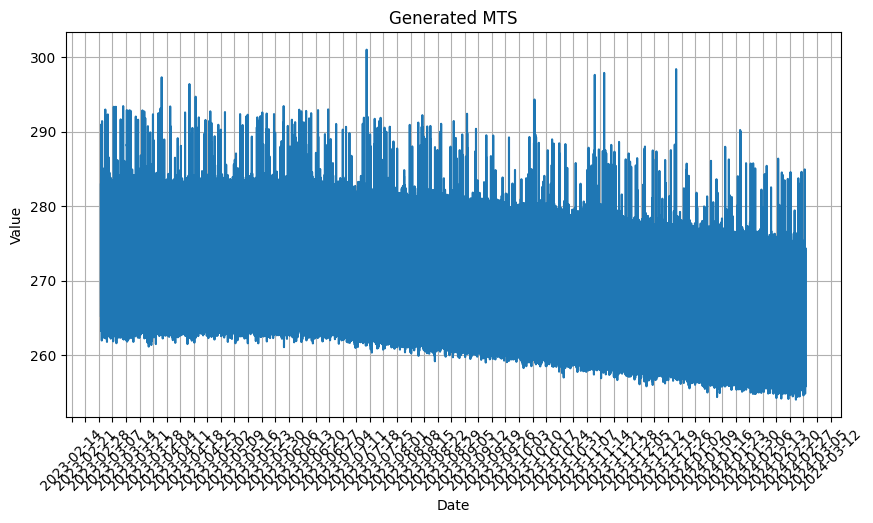

In [4]:
train_data_long, val_data_long, test_data_long, X_long = generate_long_data(args,
                                                                            effects,
                                                                            effect="both",
                                                                            occurance=1,
                                                                            return_gen=True,
                                                                            anomalies=True)

In [5]:
seas = {"occurances":1,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":0.8
        }
trend = {"occurances":1,
        "max_slope":0.002,
        "type":"linear",
        "start":0.8
        }

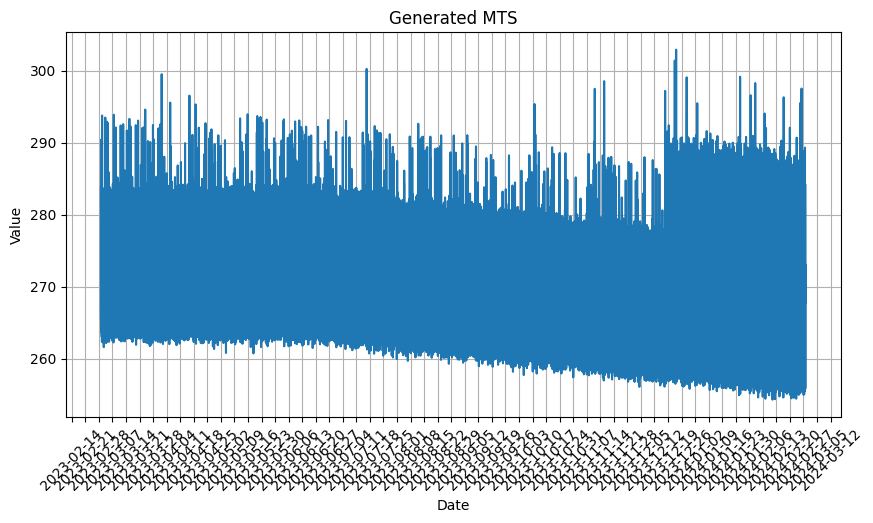

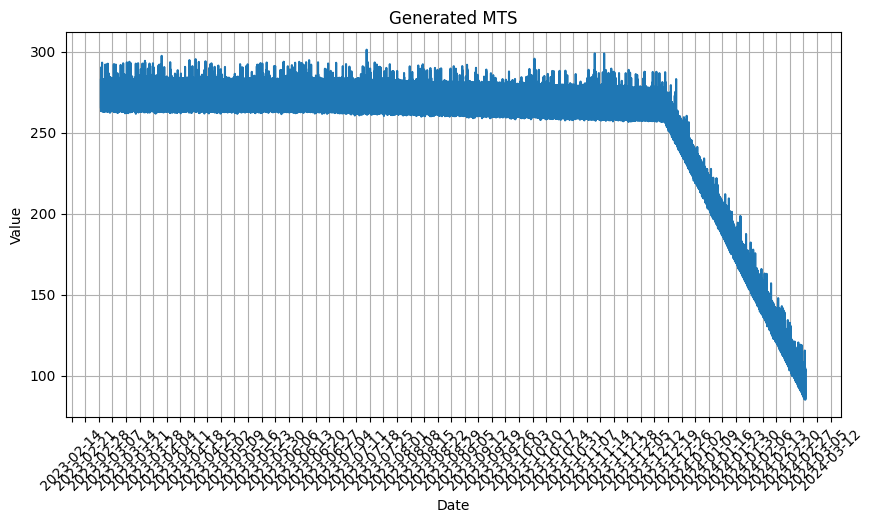

In [6]:
train_data_long_seas, val_data_long_seas, test_data_long_seas, X_long_seas = add_anomaly_long(X_long, args,
                                                                                              "Seasonality", 
                                                                                              seas, 
                                                                                              return_gen=True)
train_data_long_trend, val_data_long_trend, test_data_long_trend, X_long_trend = add_anomaly_long(X_long, args,
                                                                                              "Trend", 
                                                                                              trend, 
                                                                                              return_gen=True)

In [7]:
Origin_norm_long, REC_norm_long, _ = rebuild_TS_non_overlapping(vae, train_data_long, args, keep_norm=False)
denoised_rec_long = denoise_data(REC_norm_long.T.cpu())
denoised_orig_long = denoise_data(Origin_norm_long.T.cpu())
train_data_long_denoised = DataLoader(StridedWindow(torch.from_numpy(denoised_orig_long), args),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

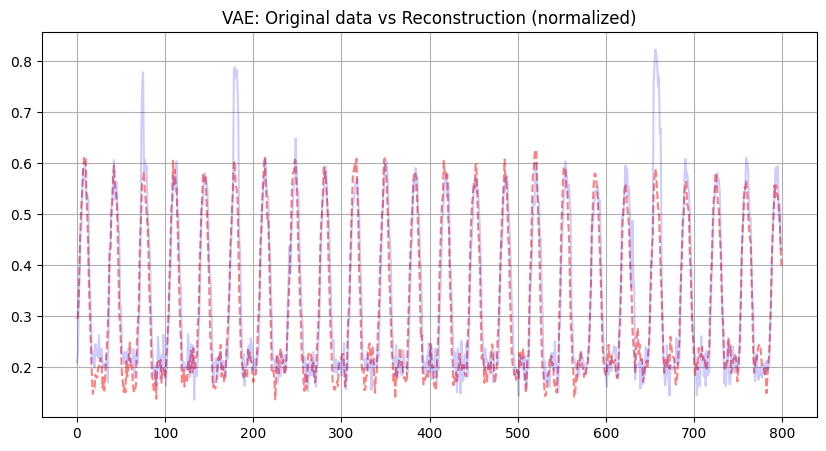

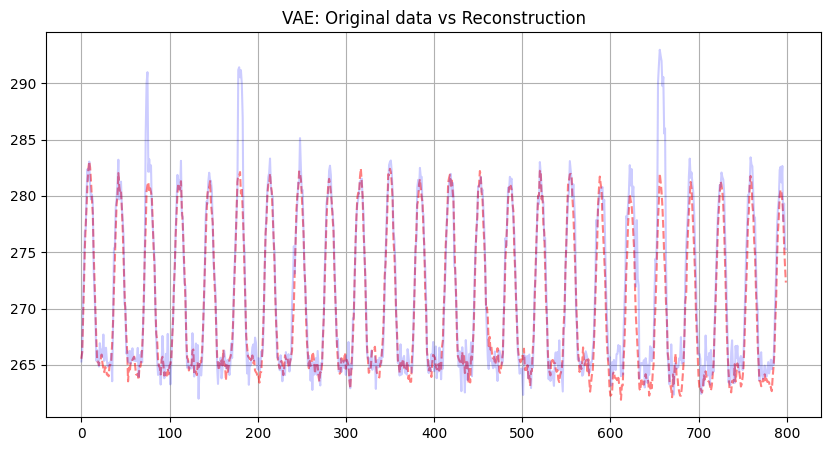

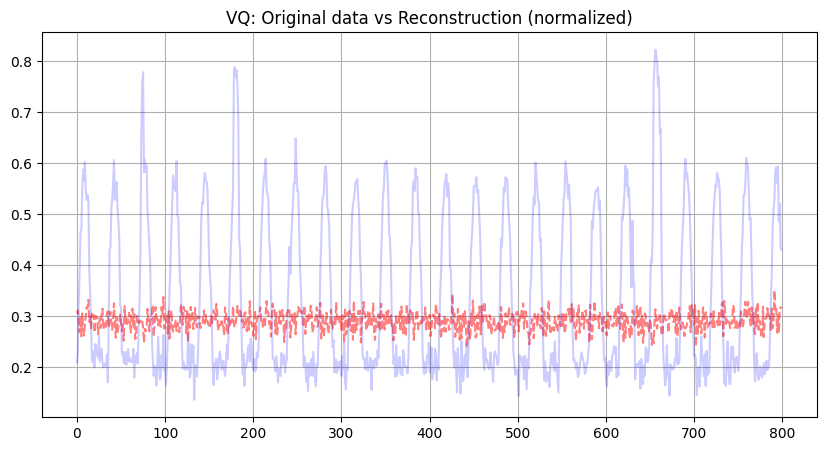

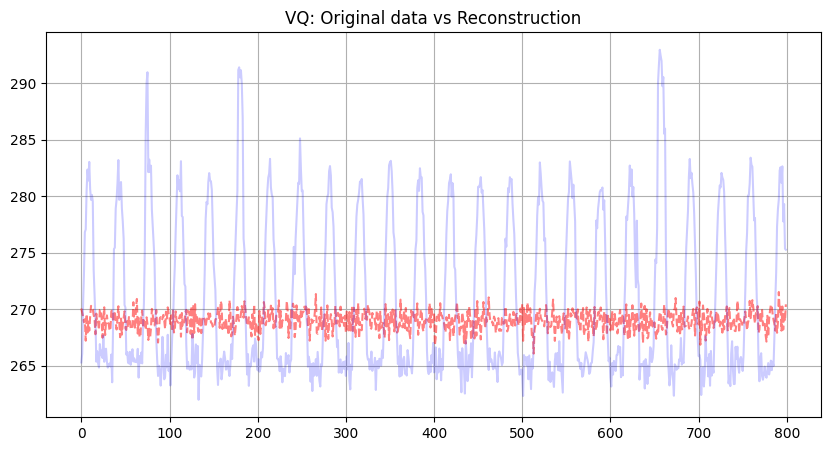

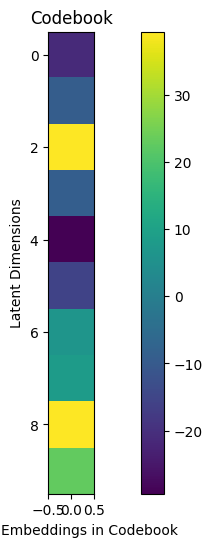

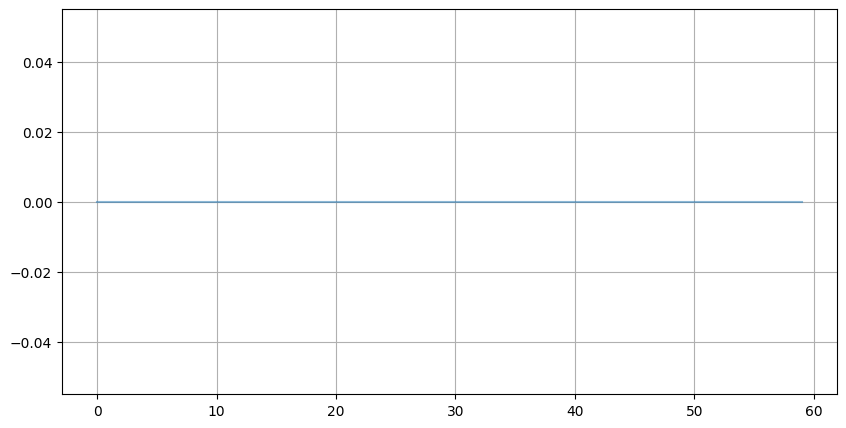

====> VAE: Sample 1901 Average loss: 0.0183
====> VQ: Sample 1901 Average loss: 0.2439
Train Epoch: 1902 [0/1 (0%)]	Loss: 2.663262	 True Loss: 386.173035
Train Epoch: 1902 [0/1 (0%)]	Loss: 35.180071	 True Loss: 5101.110352
====> VAE: Sample 1902 Average loss: 0.0184
====> VQ: Sample 1902 Average loss: 0.2426
Train Epoch: 1903 [0/1 (0%)]	Loss: 2.653631	 True Loss: 384.776428
Train Epoch: 1903 [0/1 (0%)]	Loss: 35.139675	 True Loss: 5095.252930
====> VAE: Sample 1903 Average loss: 0.0183
====> VQ: Sample 1903 Average loss: 0.2423
Train Epoch: 1904 [0/1 (0%)]	Loss: 2.721642	 True Loss: 394.638123
Train Epoch: 1904 [0/1 (0%)]	Loss: 35.047996	 True Loss: 5081.959473
====> VAE: Sample 1904 Average loss: 0.0188
====> VQ: Sample 1904 Average loss: 0.2417
Train Epoch: 1905 [0/1 (0%)]	Loss: 2.699336	 True Loss: 391.403656
Train Epoch: 1905 [0/1 (0%)]	Loss: 35.054061	 True Loss: 5082.838867
====> VAE: Sample 1905 Average loss: 0.0186
====> VQ: Sample 1905 Average loss: 0.2418
Train Epoch: 1906 [0/

Train Epoch: 1940 [0/1 (0%)]	Loss: 35.316130	 True Loss: 5120.838867
====> VAE: Sample 1940 Average loss: 0.0187
====> VQ: Sample 1940 Average loss: 0.2436
Train Epoch: 1941 [0/1 (0%)]	Loss: 2.622495	 True Loss: 380.261719
Train Epoch: 1941 [0/1 (0%)]	Loss: 35.300020	 True Loss: 5118.502930
====> VAE: Sample 1941 Average loss: 0.0181
====> VQ: Sample 1941 Average loss: 0.2434
Train Epoch: 1942 [0/1 (0%)]	Loss: 2.705754	 True Loss: 392.334351
Train Epoch: 1942 [0/1 (0%)]	Loss: 35.121606	 True Loss: 5092.632812
====> VAE: Sample 1942 Average loss: 0.0187
====> VQ: Sample 1942 Average loss: 0.2422
Train Epoch: 1943 [0/1 (0%)]	Loss: 2.736872	 True Loss: 396.846436
Train Epoch: 1943 [0/1 (0%)]	Loss: 35.072225	 True Loss: 5085.472656
====> VAE: Sample 1943 Average loss: 0.0189
====> VQ: Sample 1943 Average loss: 0.2419
Train Epoch: 1944 [0/1 (0%)]	Loss: 2.767033	 True Loss: 401.219757
Train Epoch: 1944 [0/1 (0%)]	Loss: 34.921892	 True Loss: 5063.674316
====> VAE: Sample 1944 Average loss: 0.

Train Epoch: 1979 [0/1 (0%)]	Loss: 34.249044	 True Loss: 4966.111328
====> VAE: Sample 1979 Average loss: 0.0186
====> VQ: Sample 1979 Average loss: 0.2362
Train Epoch: 1980 [0/1 (0%)]	Loss: 2.737270	 True Loss: 396.904205
Train Epoch: 1980 [0/1 (0%)]	Loss: 34.236941	 True Loss: 4964.356445
====> VAE: Sample 1980 Average loss: 0.0189
====> VQ: Sample 1980 Average loss: 0.2361
Train Epoch: 1981 [0/1 (0%)]	Loss: 2.754468	 True Loss: 399.397888
Train Epoch: 1981 [0/1 (0%)]	Loss: 34.295589	 True Loss: 4972.860352
====> VAE: Sample 1981 Average loss: 0.0190
====> VQ: Sample 1981 Average loss: 0.2365
Train Epoch: 1982 [0/1 (0%)]	Loss: 2.671593	 True Loss: 387.380981
Train Epoch: 1982 [0/1 (0%)]	Loss: 34.332267	 True Loss: 4978.178711
====> VAE: Sample 1982 Average loss: 0.0184
====> VQ: Sample 1982 Average loss: 0.2368
Train Epoch: 1983 [0/1 (0%)]	Loss: 2.690119	 True Loss: 390.067261
Train Epoch: 1983 [0/1 (0%)]	Loss: 34.354795	 True Loss: 4981.445312
====> VAE: Sample 1983 Average loss: 0.

In [345]:
args.min_max= True
np.set_printoptions(suppress=True)
VAE_losses = []
VQ_losses = []
args.robust= False

for epoch in range(1, 2000):
    loss_vae = train(vae, train_data_long, args, opt_vae, epoch)
    loss_vq = train(vq, train_data_long, args, opt_vq, epoch)
    
    if epoch%100 == 1:
        display.clear_output(wait=True)
        show_results_long(vae, train_data_long, args)
        show_results_long(vq, train_data_long, args, vq=True)
        
    VAE_losses.append(loss_vae)
    VQ_losses.append(loss_vq)
                
    print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data_long.dataset)))
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data_long.dataset)))

ValueError: too many values to unpack (expected 4)

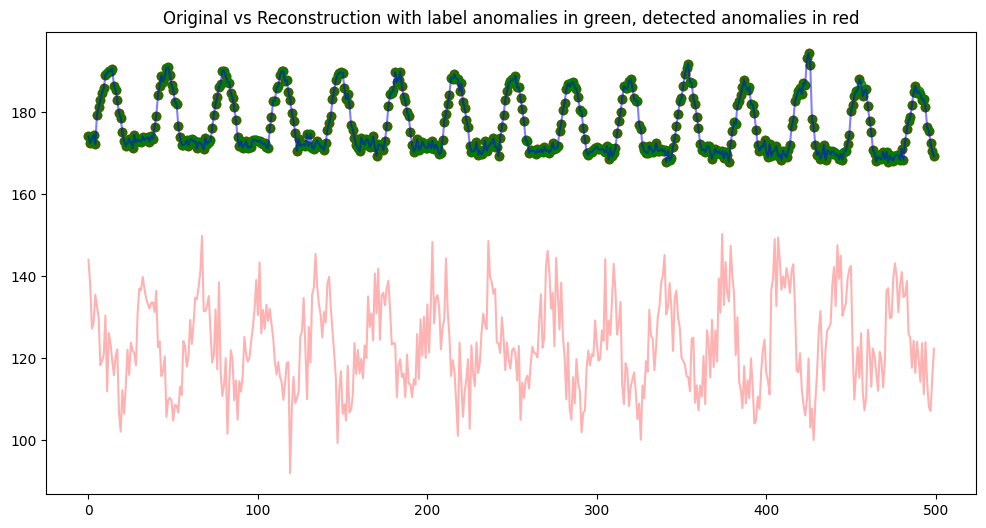

In [346]:
labels, anomalies_mask, anomalies, y_scores = get_anomalies_predictions_and_labels(vae, test_data_long_trend, args, X_long, X_long_trend, test=True)

0.6120756172839507
0.4744603965230979
0.3895267985699559


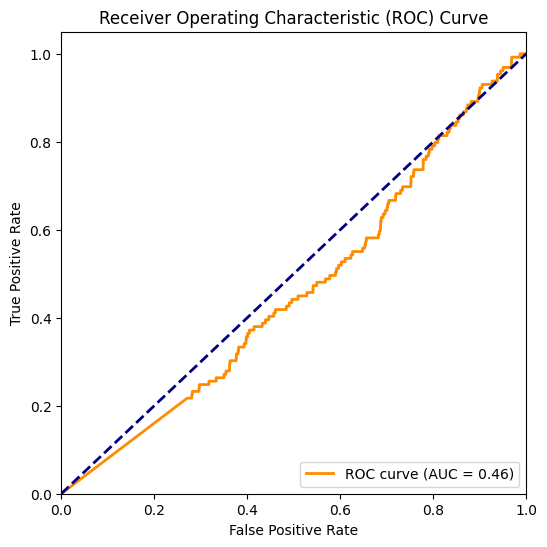

In [251]:
from anomalyDetection import *
# vae_labels = get_anomalies_labels(X_long, vq, train_data_long, args, norm=False, group_size=1)
# vae_predictions = get_anomalies_prediction(X_long, vq, train_data_long, args, norm=False, group_size=1, threshold=40)

for i, (label, pred) in enumerate(zip(labels, anomalies_mask)):
#     print(label.shape)
#     print(len(np.where(label==False)[0]))
    accuracy = accuracy_score(label, pred)
    print(accuracy)
    recall = recall_score(label.T, pred.T, average='macro')
    print(recall)
    f1 = f1_score(label.T, pred.T, average='macro')
    print(f1)

    fpr, tpr, thresholds = roc_curve(label, y_scores[i], drop_intermediate=False)
#     print(tpr.shape)
    roc_auc = auc(fpr, tpr)   # roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


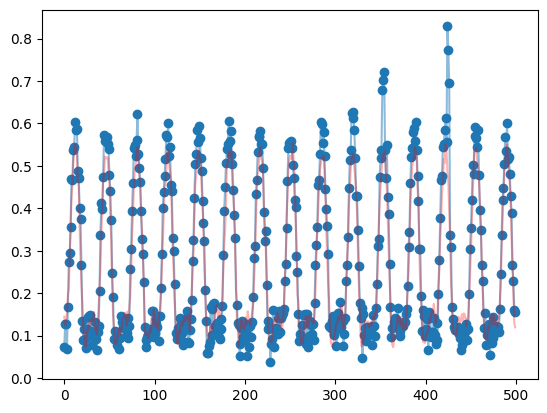

In [238]:
k = 500
sector_anomalies = get_anomalies_sector(anomalies, k)
Origin, REC, _ = rebuild_TS_non_overlapping(vq, test_data_long, args, keep_norm=True)

plt.plot(Origin.cpu()[:k], alpha=0.5)
plt.plot(REC.cpu()[:k], "-r", alpha=0.3)
plt.scatter(sector_anomalies, Origin[sector_anomalies].cpu())

In [97]:
pulse_mask = get_pulse_anomalies_labels_mask(X_long, args)

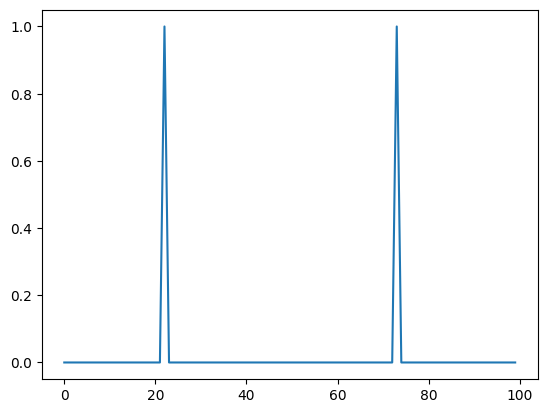

In [98]:
plt.plot(pulse_mask.T[:100])

In [246]:
Origin, REC, _ = rebuild_TS_non_overlapping(vq, train_data_long_trend, args, keep_norm=False)
    
rec_loss = get_rec_loss(vq, train_data_long, args, keep_norm=True)
y_scores = get_y_scores(rec_loss, args)


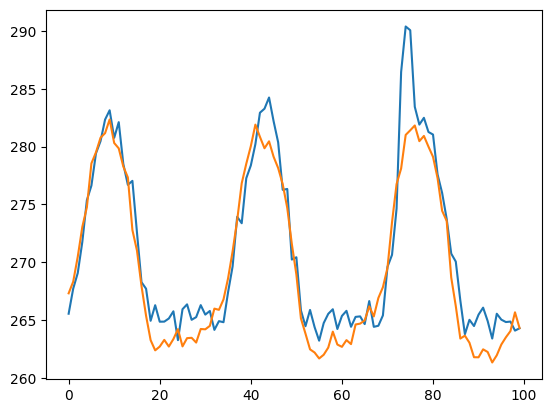

In [247]:
plt.plot(Origin[:100].cpu())
plt.plot(REC[:100].cpu())

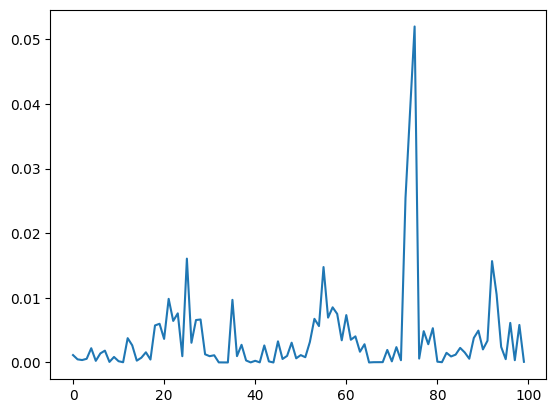

In [248]:
plt.plot(rec_loss.cpu()[:100])

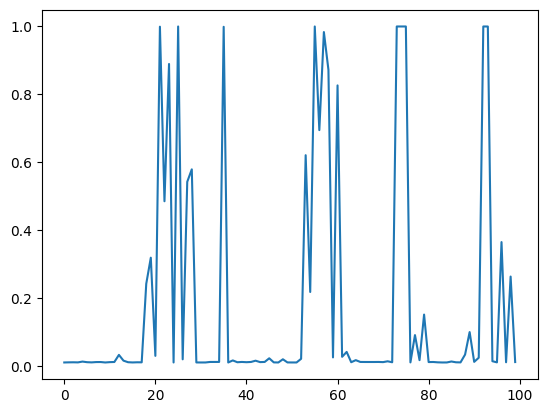

In [249]:
plt.plot(y_scores.T[:100])

In [159]:
# rec_loss = get_rec_loss(vae, test_data_long_trend, args)
# y_scores = get_y_scores(rec_loss, args)
# anomalies = get_anomalies_from_y_scores(y_scores, args)
# y_scores.shape

def get_anomalies_predictions_and_labels(model, data, args, X, X_an, test=True):
    Origin, REC, _ = rebuild_TS_non_overlapping(model, data, args, keep_norm=False)
    
    rec_loss = get_rec_loss(model, data, args)
    y_scores = get_y_scores(rec_loss, args)
    n = y_scores.shape[-1]
    
    anomalies, anomalies_mask = get_anomalies_from_y_scores(y_scores, args)
    
    label_mask = get_anomalies_label_mask(X, X_an, args)
    
    labels = get_anomalies_label(label_mask, args, n, test=test)
    
    return labels, anomalies_mask, anomalies, y_scores

In [117]:
labels.shape

(1, 10368)

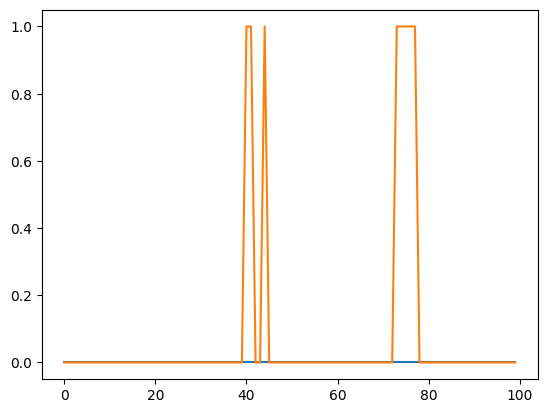

In [161]:
plt.plot(labels.T[:100])
plt.plot(anomalies_mask.T[:100])

In [ ]:
plt.plot(y_scores[0, :1000].T)

In [354]:
def get_pulse_anomalies_labels_mask(X, args):
    
    x, params, e_params = X.parameters()
    
    if e_params['Pulse']["channel"] == []:
        print("There's no Pulse Anomalies in the given data")
        return

    channels = e_params['Pulse']["channel"][0]
    indexes = e_params['Pulse']["index"][0]
    
    #Create a mask for pulse anomalies
    mask = np.full((args.n_channels, x.shape[-1]), False)
    mask[channels, indexes] = True
    
    return mask
def get_other_anomalies_labels_mask2(X, args, n_test=10368):
    
    x, params, e_params = X.parameters()
    
    mask = np.full((args.n_channels, x.shape[-1]), False)
    mask[:, -n_test:] = True
    

#     for channel in range(args.n_channels):
#         anomalies = np.where(an[:, channel] > 5)[1]
#         mask[channel, anomalies] = True
    
    return mask
def get_other_anomalies_labels_mask(X, X_an, args, n_test=10368):
    
    x, params, e_params = X.parameters()
    x_an, params_an, e_params_an = X_an.parameters()
    n = x.shape[-1]
    n_train= n - n_test
    
    an = np.abs(x_an-x)
#     plt.plot(an[0].T)
    mask = np.full((args.n_channels, x.shape[-1]), False)
    

    for channel in range(args.n_channels):
        anomalies = np.where(an[:, channel] > 5)[1]
        mask[channel, anomalies] = True
    mask[:, :n_train] = False
    
    return mask
def get_anomalies_label_mask(X, X_an, args):
    
    pulse_mask = get_pulse_anomalies_labels_mask(X, args)
    other_mask = get_other_anomalies_labels_mask(X, X_an, args)
    anomalies_mask = pulse_mask | other_mask
    print("Pulse Mask shape:", pulse_mask.shape)
    print("Other Maske. shape: ", other_mask.shape)
    print("Anomalies Maske. shape: ", other_mask.shape)
    print("both plotted")
    fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(20, 16))
    axs[0].plot(pulse_mask.T[:500])
    axs[1].plot(other_mask.T[:500])
    axs[2].plot(anomalies_mask.T[:500])
    return anomalies_mask

def get_anomalies_label(mask, args, n, test=True):
#     fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(20, 16))
#     axs[0].plot(mask.T)
    print("Input Mask shape:", mask.shape)
    
    mask = mask[:, -n:] if test else mask[:, :n]  
#     axs[1].plot(mask.T)
    
    reshaped_mask = mask.reshape(args.n_channels, -1, 1) # Reduce the size of mask (grouped values)
    
    labels = np.any(reshaped_mask, axis=2) # Get labels
#     axs[2].plot(labels.T)
    
    print("Sliced Mask shape:", mask.shape)
    print("Reshaped Maske. shape: ", reshaped_mask.shape)
    print("labels Maske. shape: ", labels.shape)
    
    
    return labels

def get_rec_loss(model, data, args, keep_norm=True):
    Origin, REC, _ = rebuild_TS_non_overlapping(model, data, args, keep_norm=keep_norm)
    rec_loss = (REC - Origin)**2
    
    fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(20, 16))
    axs[0].plot(Origin[:500].cpu())
    axs[0].plot(REC[:500].cpu())
    axs[0].set_title("Original vs Rec")
    axs[1].plot(rec_loss.cpu()[:500])
    axs[1].set_title("Reconstruction Loss")
    
    return rec_loss

def get_y_scores(rec_loss, args, n_comp=2):
    
    y_scores = np.empty((args.n_channels, rec_loss.shape[0]))
    
    for i in range(args.n_channels):
        rec =rec_loss[:,i].reshape(-1, 1).cpu().numpy()
        gmm = GaussianMixture(n_components=n_comp, random_state=0)  
        gmm.fit(rec)

        # Get the estimated probabilities of being in each component
        outlier_probabilities = gmm.predict_proba(rec)[:, 0]  # Probability of being in the first component
        y_scores[i] = 1-outlier_probabilities

    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12, 6))
    ax.plot(y_scores.T[:500])
    ax.set_title("y scores")
    
    return y_scores

def get_anomalies_from_y_scores(y_scores, args):
    #Create a mask for the anomalies
    anomalies_mask = np.full(y_scores.shape, False)

    for i in range(args.n_channels):
        anomalies = np.where(y_scores[i] > 0.99)[0]
        anomalies_mask[i, anomalies] = True

    return anomalies, anomalies_mask

def get_anomalies_sector(anomalies, max_length=500):
    some_anomalies = np.where(anomalies<max_length)[0]
    sector_anomalies = anomalies[some_anomalies]
    return sector_anomalies

def get_anomalies_predictions_and_labels(model, data, args, X, X_an, test=True):
    Origin, REC, _ = rebuild_TS_non_overlapping(model, data, args, keep_norm=False)
    
    rec_loss = get_rec_loss(model, data, args)
    y_scores = get_y_scores(rec_loss, args)
    n = y_scores.shape[-1]
    
    anomalies_index, anomalies_mask = get_anomalies_from_y_scores(y_scores, args)
    
    labels = get_anomalies_label_mask(X, X_an, args)    
    labels_mask = get_anomalies_label(labels, args, n, test=test)
    labels_index = []
    for i in range(args.n_channels):
        label_index = np.where(labels_mask[i] > 0)[0]
        labels_index.append(label_index) 
        
    k = 500
    sector_anomalies = get_anomalies_sector(anomalies_index, k)
    sector_labels = get_anomalies_sector(labels_index[0], k)
    
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12, 6))
    ax.plot(Origin.cpu()[:k], "b", alpha=0.5)
    ax.plot(REC.cpu()[:k], "-r", alpha=0.3)
    ax.scatter(sector_anomalies, Origin[sector_anomalies].cpu(), c="r")
    ax.scatter(sector_labels, Origin[sector_labels].cpu(), c="g", alpha= 0.8)
    ax.set_title("Original vs Reconstruction with label anomalies in green, detected anomalies in red")
    
    
    return labels_mask, labels_index, anomalies_mask, anomalies_index, y_scores

Pulse Mask shape: (1, 104832)
Other Maske. shape:  (1, 104832)
Anomalies Maske. shape:  (1, 104832)
both plotted
Input Mask shape: (1, 104832)
Sliced Mask shape: (1, 10368)
Reshaped Maske. shape:  (1, 10368, 1)
labels Maske. shape:  (1, 10368)


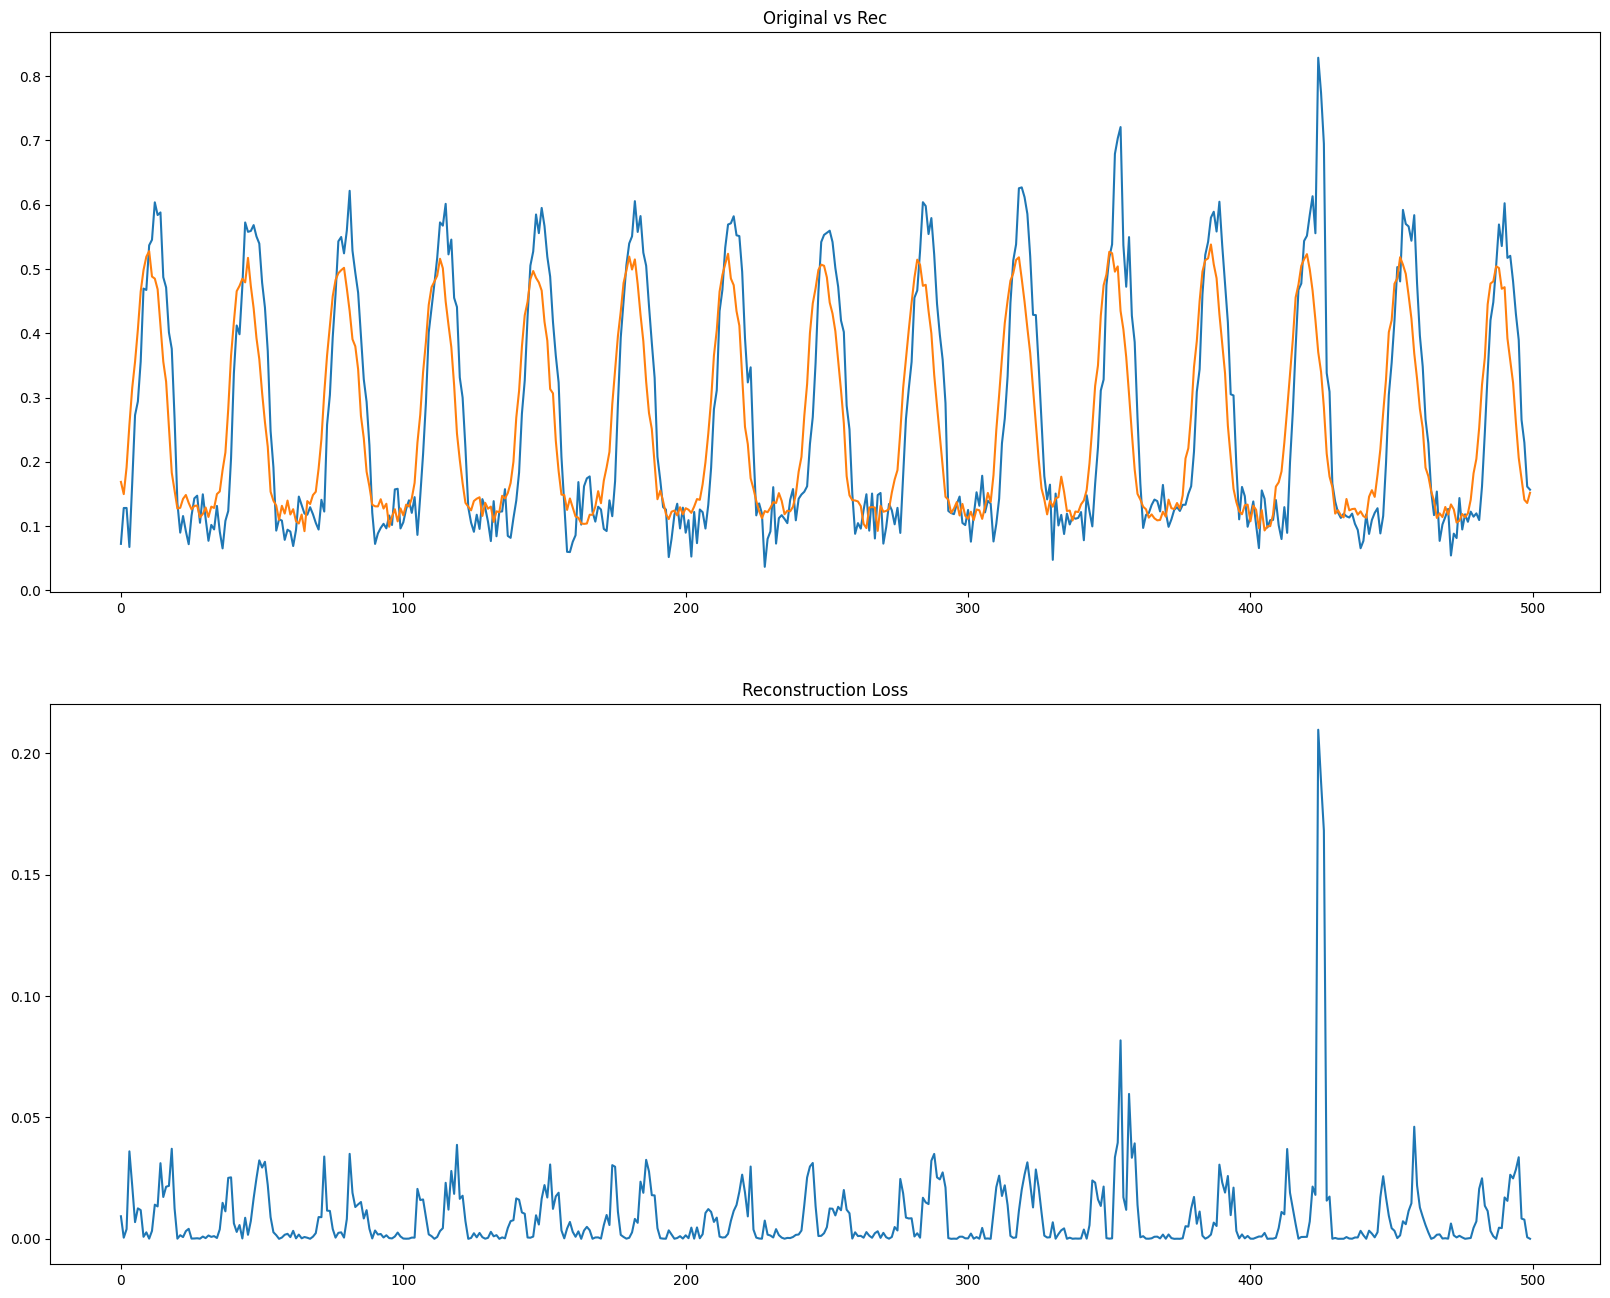

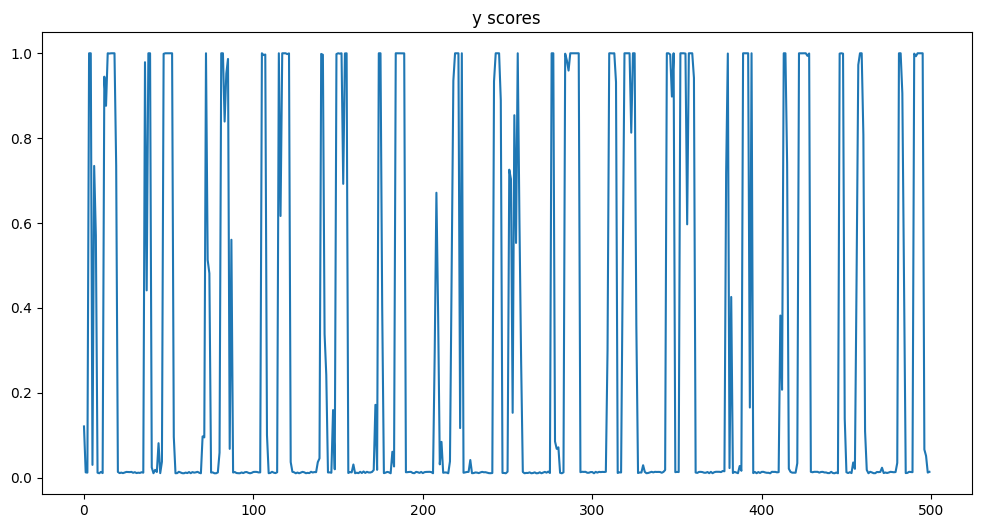

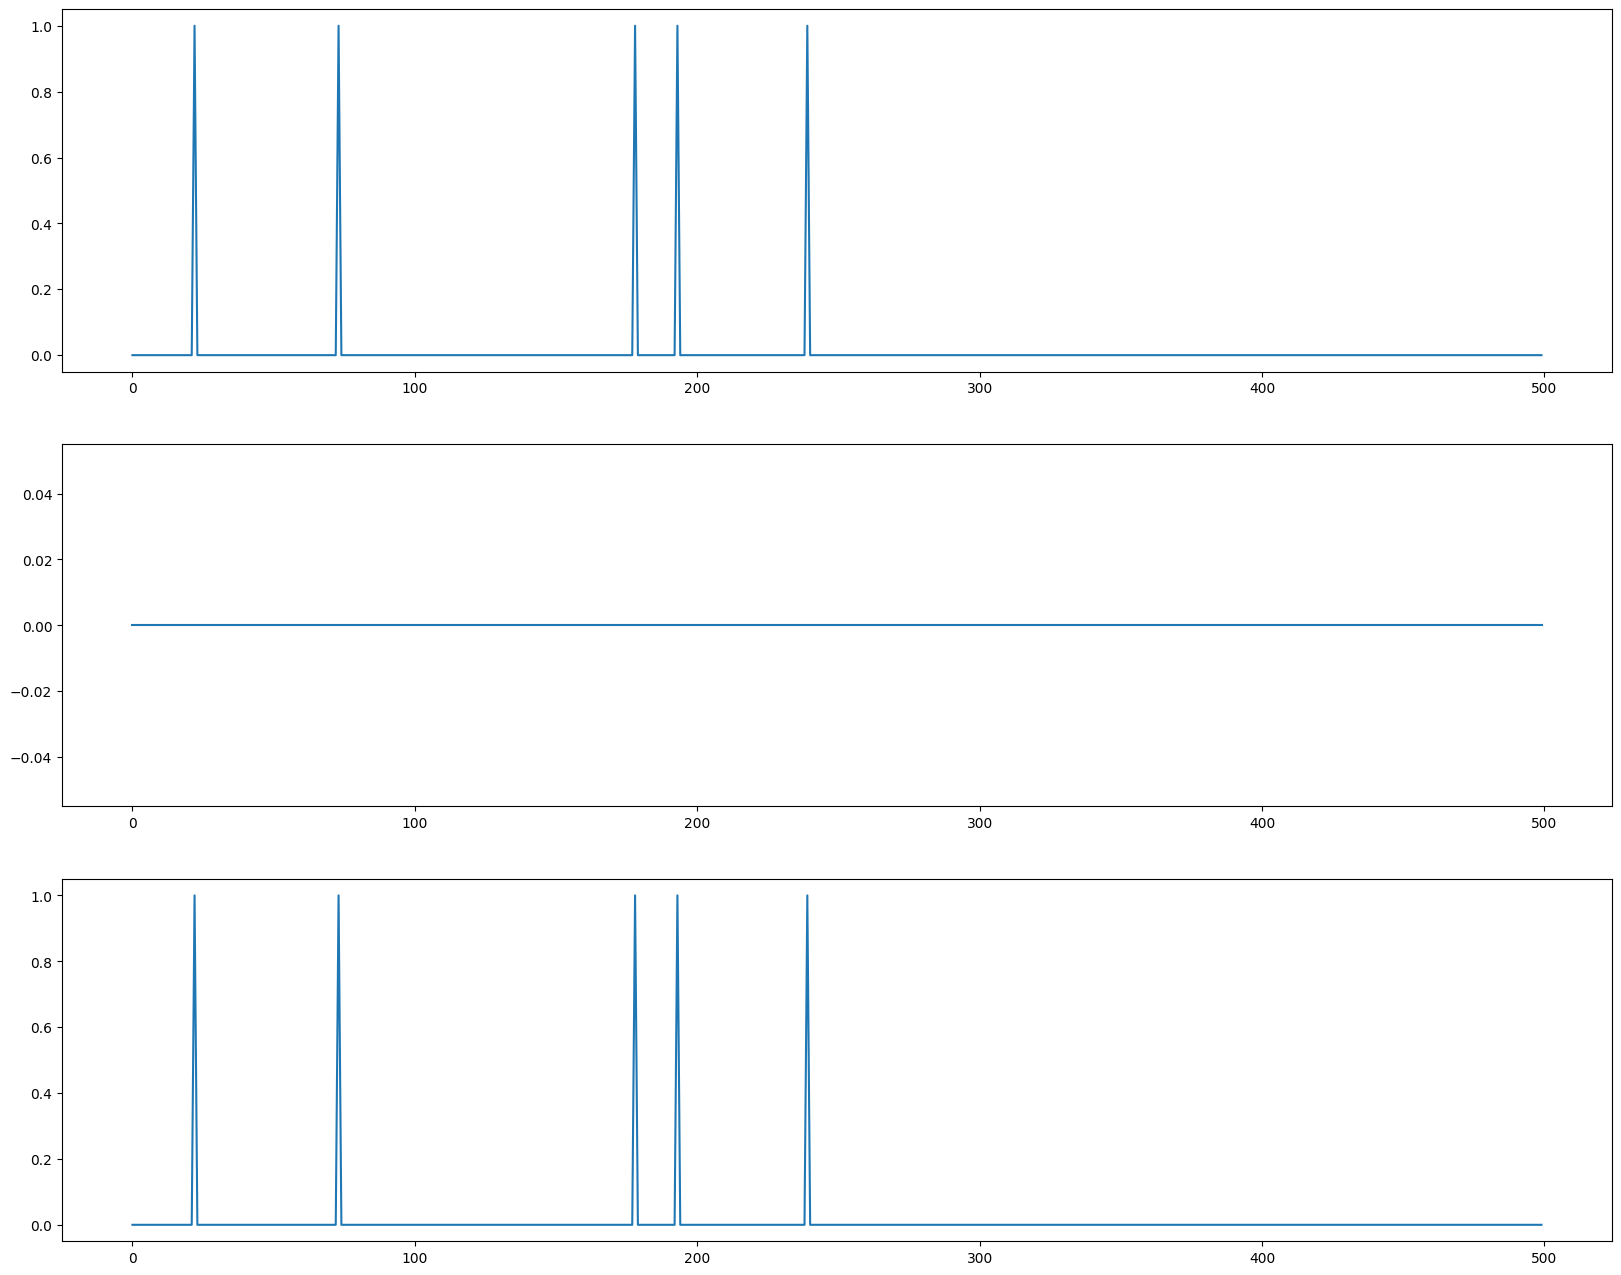

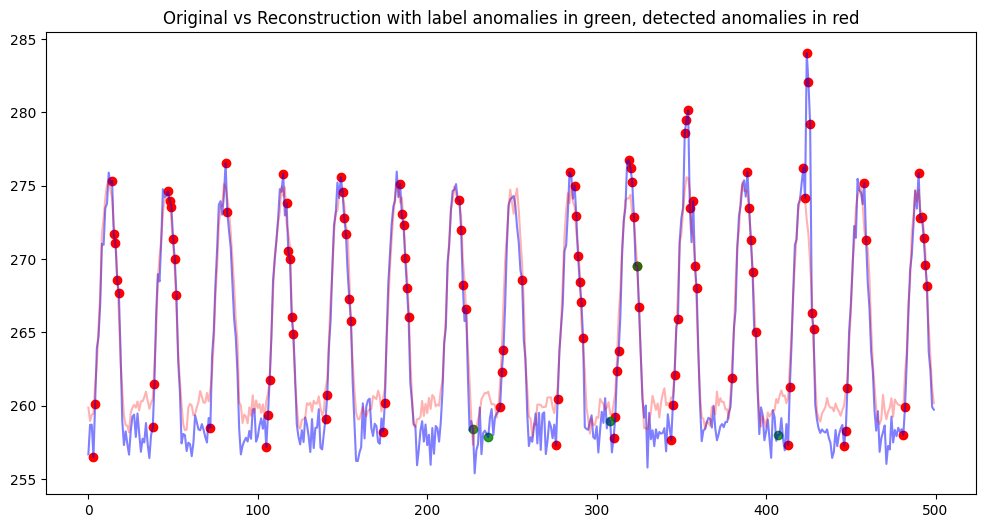

In [357]:
labels_mask, labels_index, anomalies_mask, anomalies, y_scores = get_anomalies_predictions_and_labels(vae, 
                                                                                                     test_data_long, 
                                                                                                     args, 
                                                                                                     X_long, 
                                                                                                     X_long, 
                                                                                                     test=True)